In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
# Функция для вычисления метрик
def evaluate_clustering(X, true_labels, pred_labels, dataset_name, algorithm_name, use_internal=False):
    # Внутренние метрики
    silhouette = silhouette_score(X, pred_labels)
    calinski = calinski_harabasz_score(X, pred_labels)
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Index: {calinski:.3f}")
    
    if use_internal:
        # Внешние метрики (требуют истинных меток)
        ari = adjusted_rand_score(true_labels, pred_labels)
        nmi = normalized_mutual_info_score(true_labels, pred_labels)
        
        print(f"Оценка {algorithm_name} на {dataset_name}:")
        print(f"Adjusted Rand Index (ARI): {ari:.3f}")
        print(f"Normalized Mutual Info (NMI): {nmi:.3f}")
    print()

### Внешние и внутренние метрики 
- Внешние метрики кластеризации используют, когда есть заранее известная информация об истинных метках кластеров. Такие метрики позволяют оценить точность и сходство между реальными и предсказанными кластерами. Adjusted Rand Index (ARI) - сходство между предсказанными и истинными кластерами, корректируя случайные совпадения. Normalized Mutual Info (NMI) - количество информации, общей для истинных и предсказанных кластеров.
- Внутренние метрики кластеризации применяют, когда нет заранее известных меток. Такие метрики позволяют оценить плотность и качество внутрикластерных связей без использования внешней информации. Silhouette Score - насколько компактно расположены объекты внутри кластеров и насколько хорошо они отделены от других кластеров. Calinski-Harabasz Index - соотношение дисперсии внутри кластеров и между кластерами.


### Два варианта генерации синтетических данных:

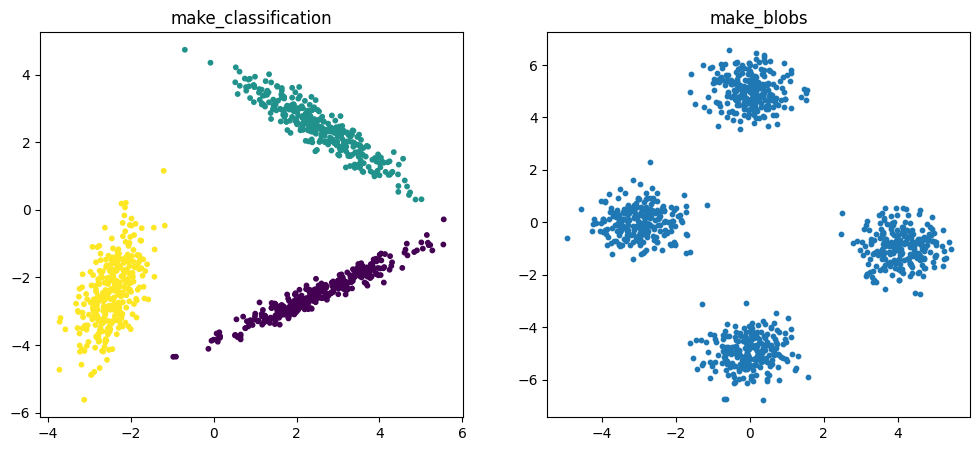

In [3]:
# Генерация синтетических данных

# Датасет 1: 3 кластера
X1, y1 = make_classification(
    n_samples=1000,
    n_features=2,
    n_classes=3,        
    n_clusters_per_class=1,
    n_redundant=0,             # Нет избыточных признаков
    class_sep=2.5,             # Увеличенное расстояние между кластерами
    flip_y=0,                  # Нет шума
    random_state=42
)

# Датасет 2
X2, y2 = make_blobs(
    n_samples=1000,
    centers=[[-3,0], [0,5], [4,-1], [0,-5]], 
    cluster_std=0.6,
    random_state=42
)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap='viridis', s=10)
plt.title("make_classification")

plt.subplot(122)
plt.scatter(X2[:,0], X2[:,1], s=10)
plt.title("make_blobs")

plt.show()

### Метод локтя: принцип работы
Метод локтя заключается в следующем: мы выполняем кластеризацию для различных значений k и строим график зависимости суммарной внутрикластерной дисперсии от количества кластеров. Внутрикластерная дисперсия (или сумма квадратов расстояний между объектами и их центроидом) показывает, насколько компактными являются кластеры. Чем меньше внутрикластерная дисперсия, тем более «упорядочены» и «однородны» кластеры.

Точка на графике, где происходит значительное снижение дисперсии, а затем снижение становится менее заметным, называется локтем. Это и есть оптимальное количество кластеров.

### Шаги алгоритма KMeans:
1. Выбрать случайно координаты центроидов для каждого кластера.
2. Посчитать расстояния от каждого объекта до центроидов.
3. Посчитать центр масс (центроид) каждого кластера.
4. Проверить условие остановки, вернуться к шагу 2.

От начального выбора центроидов зависит качество и скорость сходимости. Существуют модификации, которые улучшают случайный выбор - напр, K-means++. Суть улучшения заключается в нахождении более «хороших» начальных значений центроидов кластеров на основе поиска максимально отдалённых друг от друга потенциальных ядер кластеров.

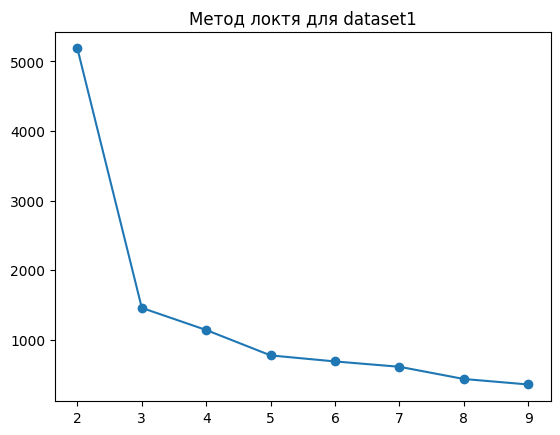

In [4]:
# K-means для dataset1
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X1)
    sse.append(kmeans.inertia_) # суммарная внутрикластерная дисперсия
plt.plot(range(2, 10), sse, marker='o')
plt.title('Метод локтя для dataset1')
plt.show()

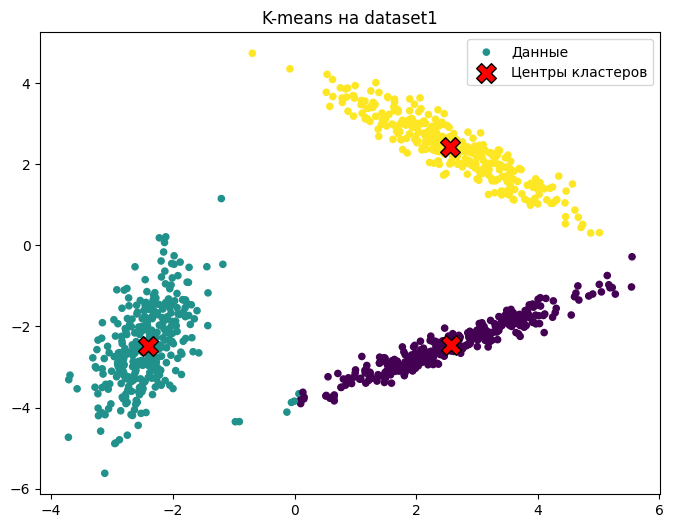

Silhouette Score: 0.702
Calinski-Harabasz Index: 3724.112
Оценка K-means на dataset1:
Adjusted Rand Index (ARI): 0.982
Normalized Mutual Info (NMI): 0.973



In [5]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X1)
labels_kmeans = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=labels_kmeans, cmap='viridis', s=20, label='Данные')
plt.scatter(
    kmeans.cluster_centers_[:, 0], 
    kmeans.cluster_centers_[:, 1], 
    s=200,                   
    marker='X',               
    c='red',                   
    edgecolor='black',     
    linewidth=1,                 
    label='Центры кластеров'
)
plt.title('K-means на dataset1')
plt.legend()
plt.show()

evaluate_clustering(X1, y1, kmeans.labels_, "dataset1", "K-means", use_internal=True)

### Метод силуэта
1. Перебирают диапазон возможных значений кластеров (например, от 2 до 8).
2. Для каждого K (числа кластеров):
- Выполняют кластеризацию (например, алгоритмом K-means).
- Рассчитывают средний силуэтный коэффициент.
3. Оптимальное K - то, при котором коэффициент максимален.

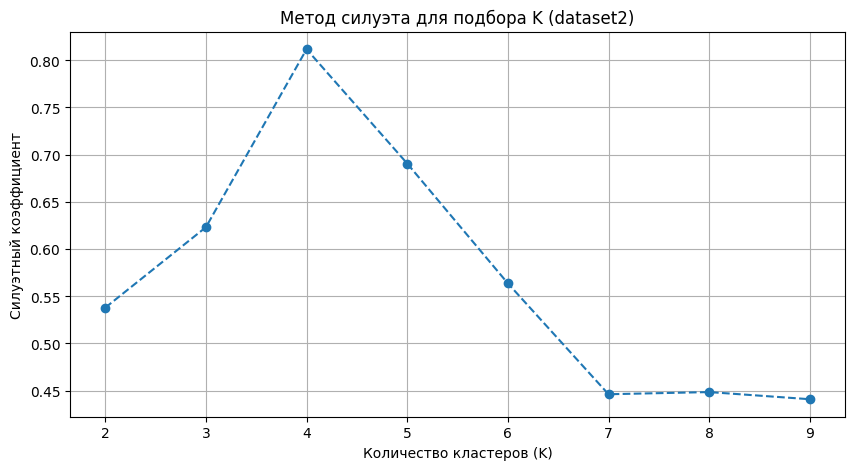

In [6]:
# Перебор значений кластеров 
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X2)
    score = silhouette_score(X2, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Силуэтный коэффициент')
plt.title('Метод силуэта для подбора K (dataset2)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

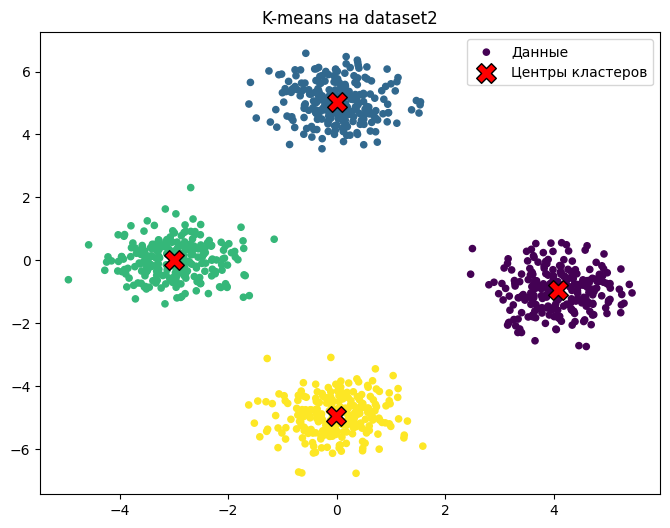

Silhouette Score: 0.812
Calinski-Harabasz Index: 8992.337



In [7]:
# K-means для dataset2
kmeans = KMeans(n_clusters=4, random_state=42).fit(X2)
labels_kmeans2 = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X2[:, 0], X2[:, 1], c=labels_kmeans2, cmap='viridis', s=20, label='Данные')
plt.scatter(
    kmeans.cluster_centers_[:, 0],  
    kmeans.cluster_centers_[:, 1],  
    s=200,                        
    marker='X',             
    c='red',                    
    edgecolor='black',       
    linewidth=1,                  
    label='Центры кластеров'
)
plt.title('K-means на dataset2')
plt.legend()
plt.show()

evaluate_clustering(X2, y2, kmeans.labels_, "dataset2", "K-means", use_internal=False)

### DBSCAN
DBSCAN — это алгоритм кластеризации на основе плотности, который группирует точки данных, расположенные близко друг к другу, и помечает выбросы как шум на основе их плотности в пространстве признаков. Он определяет кластеры как плотные области в пространстве данных, разделённые областями с меньшей плотностью.

### Параметры
1. eps: определяет радиус окрестности вокруг точки данных.
Если расстояние между двумя точками меньше или равно eps, они считаются соседними. Выбор правильного значения eps имеет решающее значение:
- Если eps слишком мало, большинство точек будут классифицированы как шум.
- Если eps слишком велико, кластеры могут слиться, и алгоритм не сможет их различить.
2. min_samples: это минимальное количество точек, необходимое в пределах eps радиуса для формирования плотной области.

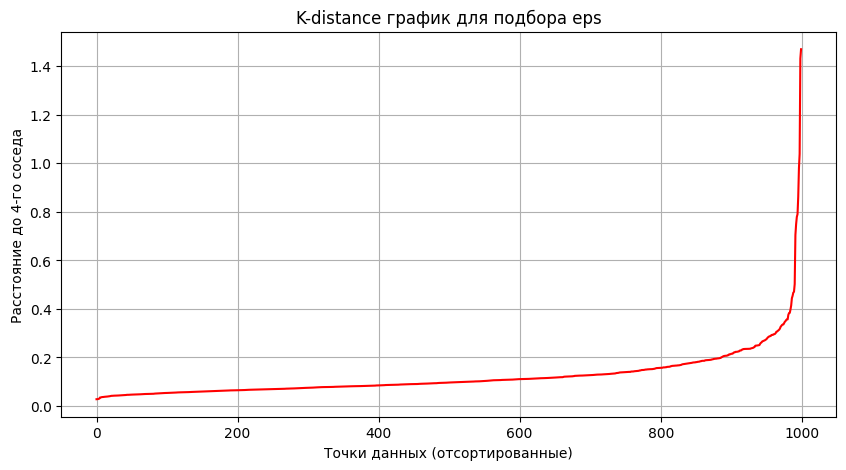

In [8]:
# DBSCAN для первого датасета
min_samples = 4   # 2 * n_features (2)
# Вычисляем расстояние до k-го соседа (k = min_samples)
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X1)
distances, _ = neighbors_fit.kneighbors(X1)

# Сортируем расстояния и строим график
k_distances = distances[:, -1] 
k_distances = np.sort(k_distances)

plt.figure(figsize=(10, 5))
plt.plot(k_distances, color='red')
plt.xlabel('Точки данных (отсортированные)')
plt.ylabel(f'Расстояние до {min_samples}-го соседа')
plt.title('K-distance график для подбора eps')
plt.grid(True)
plt.show()

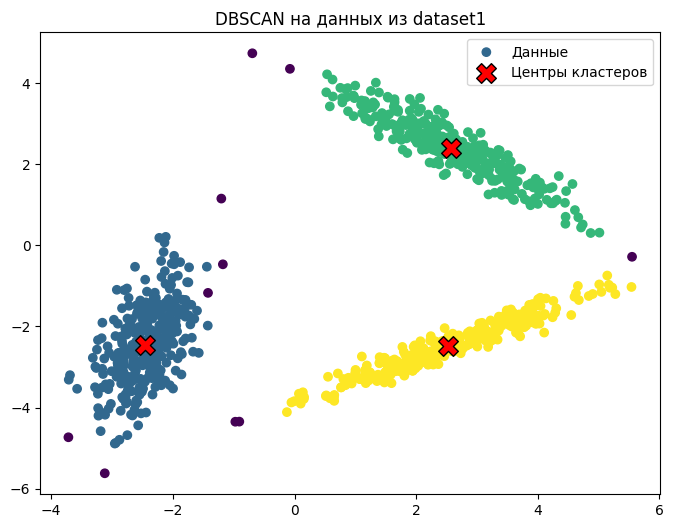

Silhouette Score: 0.680
Calinski-Harabasz Index: 2315.114
Оценка DBSCAN на dataset1:
Adjusted Rand Index (ARI): 0.985
Normalized Mutual Info (NMI): 0.971



In [9]:
dbscan = DBSCAN(eps=0.4, min_samples=4).fit(X1)
labels = dbscan.labels_

# Рассчитываем "центры" как средние точки кластеров
unique_labels = set(labels) - {-1}  # Исключаем шум
cluster_centers = []

for label in unique_labels:
    cluster_points = X1[labels == label]
    cluster_centers.append(cluster_points.mean(axis=0))

cluster_centers = np.array(cluster_centers)

plt.figure(figsize=(8, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=labels, cmap='viridis', label='Данные')

if len(cluster_centers) > 0:
    plt.scatter(
        cluster_centers[:, 0], 
        cluster_centers[:, 1],
        s=200,
        marker='X',
        c='red',
        edgecolor='black',
        linewidth=1,
        label='Центры кластеров'
    )

plt.title('DBSCAN на данных из dataset1')
plt.legend()
plt.show()
evaluate_clustering(X1, y1, dbscan.labels_, "dataset1", "DBSCAN", use_internal=True)

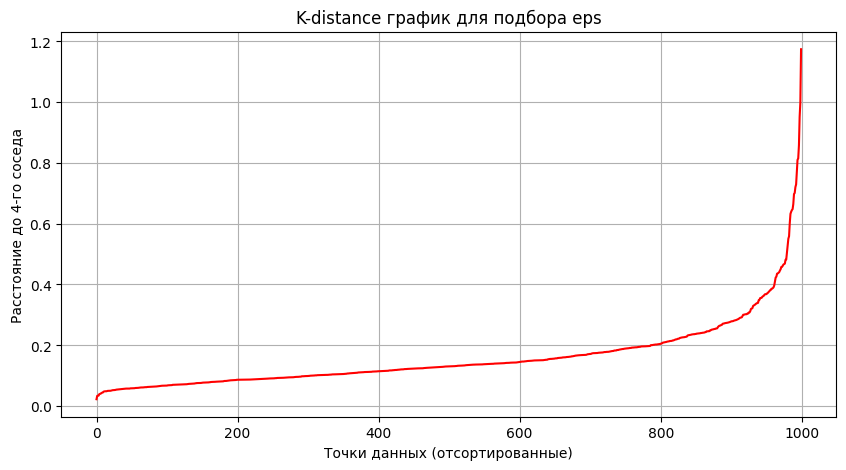

In [10]:
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X2)
distances, _ = neighbors_fit.kneighbors(X2)

k_distances = distances[:, -1]  
k_distances = np.sort(k_distances)

plt.figure(figsize=(10, 5))
plt.plot(k_distances, color='red')
plt.xlabel('Точки данных (отсортированные)')
plt.ylabel(f'Расстояние до {min_samples}-го соседа')
plt.title('K-distance график для подбора eps')
plt.grid(True)
plt.show()

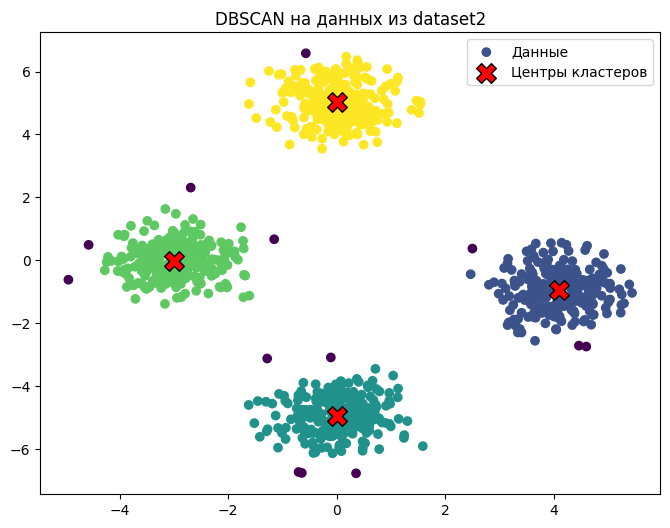

Silhouette Score: 0.790
Calinski-Harabasz Index: 4975.869



In [11]:
dbscan = DBSCAN(eps=0.5, min_samples=4).fit(X2)
labels = dbscan.labels_

# Рассчитываем центры как средние точки кластеров
unique_labels = set(labels) - {-1}  # Исключаем шум
cluster_centers = []

for label in unique_labels:
    cluster_points = X2[labels == label]
    cluster_centers.append(cluster_points.mean(axis=0))

cluster_centers = np.array(cluster_centers)

plt.figure(figsize=(8, 6))
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', label='Данные')

if len(cluster_centers) > 0:
    plt.scatter(
        cluster_centers[:, 0], 
        cluster_centers[:, 1],
        s=200,
        marker='X',
        c='red',
        edgecolor='black',
        linewidth=1,
        label='Центры кластеров'
    )

plt.title('DBSCAN на данных из dataset2')
plt.legend()
plt.show()

evaluate_clustering(X2, y2, dbscan.labels_, "dataset2", "DBSCAN", use_internal=False)


### Иерархическая кластеризация

- Алгоритм строит дерево (дендрограмму), последовательно объединяя или разделяя кластеры.
- Агломеративный (снизу вверх) подход. Каждая точка начинается как отдельный кластер. На каждом шаге объединяются два ближайших кластера. Процесс повторяется, пока не останется один кластер

- #### Как подбирать количестов кластеров? Когда сформирована дендограмма, выбирается самое длинное расстояние по вертикали. Затем через него проводится горизонатльная линия. И смотрим, сколько раз она пересекает.

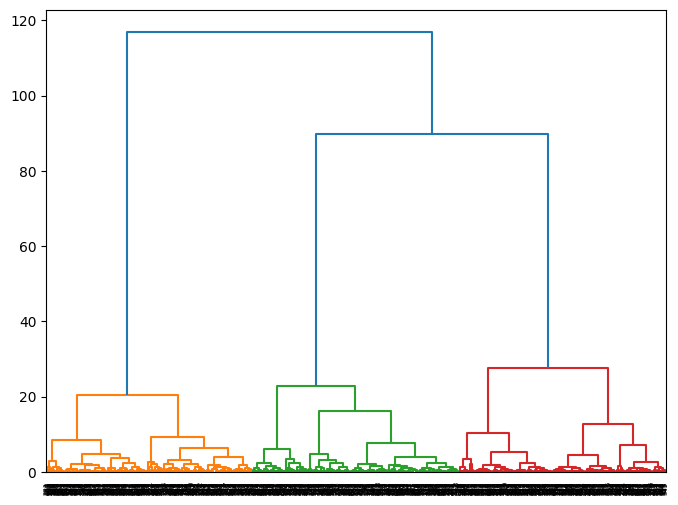

In [12]:
clusters = hierarchy.linkage(X1, method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

### Получилось 3 кластера. Проверим на силуэтном коэффициенте...

In [13]:
scores = []
for n_clusters in range(2, 10):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = model.fit_predict(X1)
    score = silhouette_score(X1, labels)
    scores.append(score)
    print(f"n_clusters={n_clusters}, score={score:.2f}")

n_clusters=2, score=0.55
n_clusters=3, score=0.70
n_clusters=4, score=0.64
n_clusters=5, score=0.56
n_clusters=6, score=0.48
n_clusters=7, score=0.48
n_clusters=8, score=0.46
n_clusters=9, score=0.47


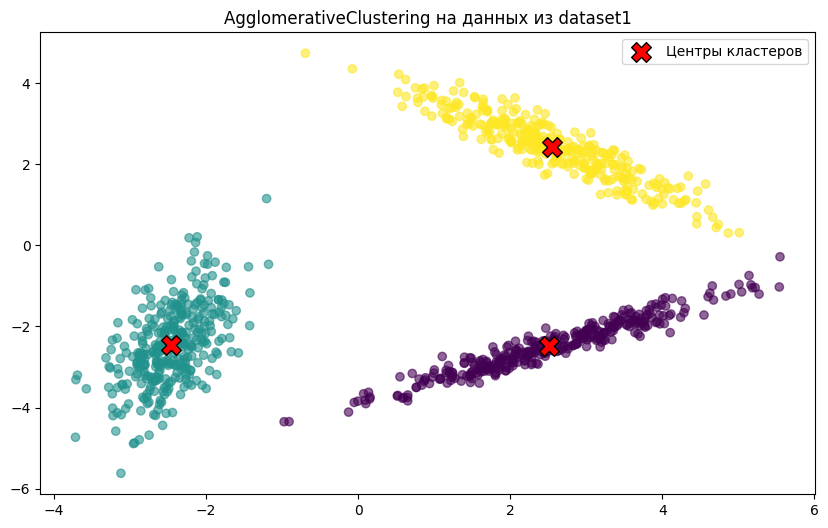

Silhouette Score: 0.701
Calinski-Harabasz Index: 3659.771
Оценка Agglomerative на dataset1:
Adjusted Rand Index (ARI): 1.000
Normalized Mutual Info (NMI): 1.000



In [14]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X1)
labels = clustering.labels_

cluster_centers = []
for cluster_id in np.unique(labels):
    cluster_points = X1[labels == cluster_id]
    cluster_centers.append(cluster_points.mean(axis=0))

cluster_centers = np.array(cluster_centers)

plt.figure(figsize=(10, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            s=200, 
            marker='X',
            c='red',
            edgecolor='black',
            linewidth=1,
            label='Центры кластеров')

plt.title('AgglomerativeClustering на данных из dataset1')
plt.legend()
plt.show()
evaluate_clustering(X1, y1, clustering.labels_, "dataset1", "Agglomerative", use_internal=True)

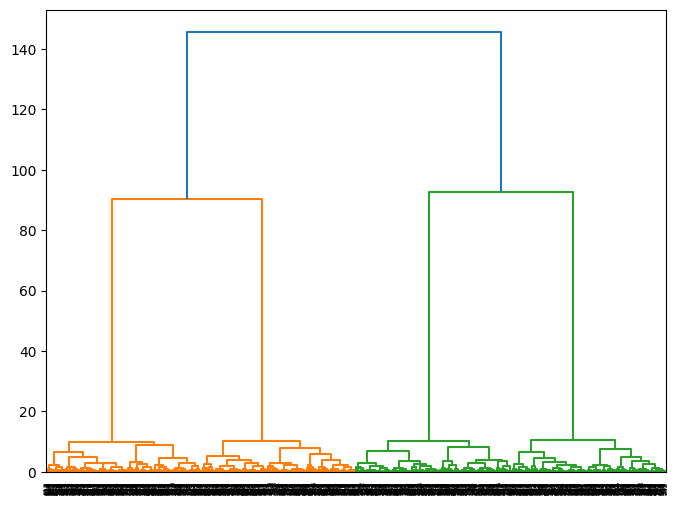

In [15]:
clusters = hierarchy.linkage(X2, method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

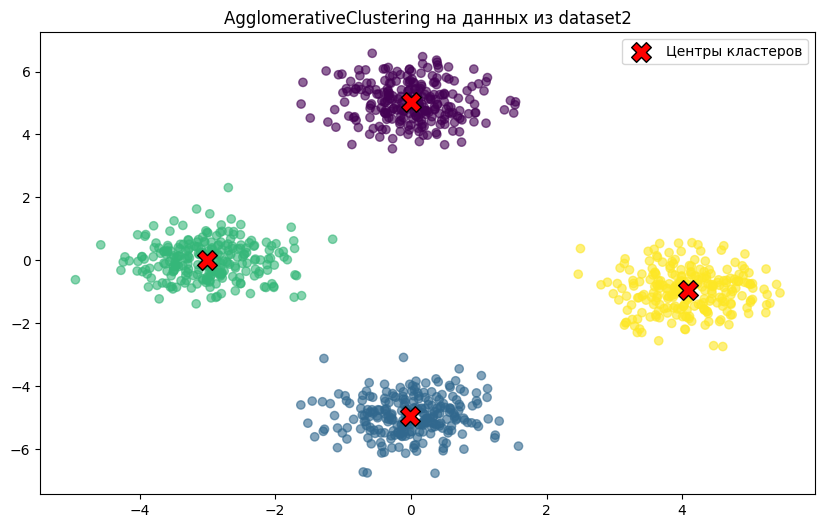

Silhouette Score: 0.812
Calinski-Harabasz Index: 8992.337



In [16]:
clustering = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X2)
labels = clustering.labels_

cluster_centers = []
for cluster_id in np.unique(labels):
    cluster_points = X2[labels == cluster_id]
    cluster_centers.append(cluster_points.mean(axis=0))

cluster_centers = np.array(cluster_centers)

plt.figure(figsize=(10, 6))
plt.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            s=200, 
            marker='X',
            c='red',
            edgecolor='black',
            linewidth=1,
            label='Центры кластеров')

plt.title('AgglomerativeClustering на данных из dataset2')
plt.legend()
plt.show()
evaluate_clustering(X2, y2, clustering.labels_, "dataset2", "Agglomerative", use_internal=False)

### EM-алгоритм
- Гауссова смесь (GMM) — это вероятностная модель, которая предполагает, что данные порождены несколькими гауссовыми (нормальными) распределениями. Каждое распределение (компонент смеси) соответствует отдельному кластеру.
- EM-алгоритм (Expectation-Maximization) — это метод для поиска параметров модели (средние, ковариации, веса компонентов) через максимизацию правдоподобия. EM-алгоритм используется для обучения GMM.


1. Инициализация: начните с предварительных оценок для средних значений, ковариаций и коэффициентов смешивания каждого гауссовского распределения.
2. E-шаг: для каждой точки данных рассчитайте вероятность её принадлежности к каждому гауссову распределению (кластеру).
3. M-шаг: обновите параметры (средние значения, ковариации, коэффициенты смешивания) с помощью вероятностей, рассчитанных на E-шаге.
4. Повторите: продолжайте чередовать E-шаг и M-шаг до тех пор, пока логарифмическая вероятность данных (показатель того, насколько хорошо модель соответствует данным) не стабилизируется.

Silhouette Score: 0.701
Calinski-Harabasz Index: 3653.995
Оценка Gaussian Mixture на dataset1:
Adjusted Rand Index (ARI): 0.997
Normalized Mutual Info (NMI): 0.994



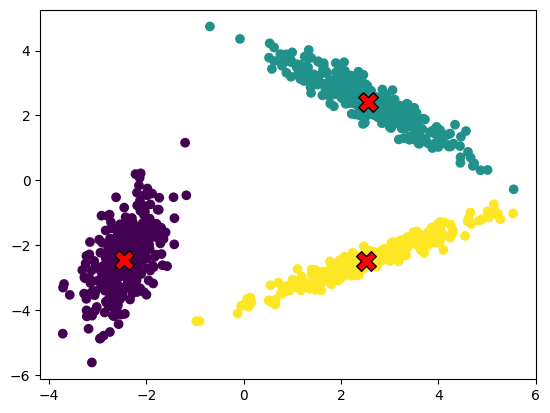

In [17]:
gm = GaussianMixture(n_components=3).fit(X1)

gm_labels = gm.predict(X1)

plt.scatter(X1[:,0], X1[:,1], c=gm.predict(X1))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=200,  marker='X', c='red', edgecolor='black', linewidth=1)
evaluate_clustering(X1, y1, gm_labels, "dataset1", "Gaussian Mixture", use_internal=True)

Silhouette Score: 0.812
Calinski-Harabasz Index: 8992.337



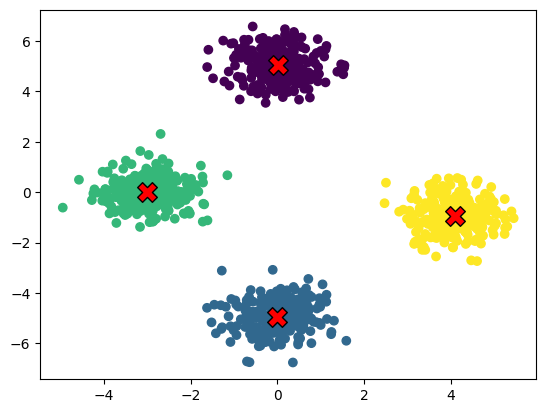

In [18]:
gm = GaussianMixture(n_components=4).fit(X2)

gm_labels2 = gm.predict(X2)

plt.scatter(X2[:,0], X2[:,1], c=gm.predict(X2))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=200,  marker='X', c='red', edgecolor='black', linewidth=1)
evaluate_clustering(X2, y2, gm_labels2, "dataset2", "Gaussian Mixture", use_internal=False)


### Affinity Propagation (AP) 
- это алгоритм кластеризации, основанный на передаче сообщений между точками данных. В отличие от других алгоритмов кластеризации, таких как K-means, AP не требует заранее определенного числа кластеров. Для этой цели двумя важными параметрами являются "preference", которые контролируют количество экземпляров и "damping factor", который снижает ответственность и доступность сообщений, чтобы избежать числовых колебаний при обновлении этих сообщений. Подбираются через поиск по сетке.

1. Инициализация: Создайте матрицу сходства S, где каждый элемент s(i, j) представляет сходство между точками данных i и j. Обычно сходство определяется как отрицательное квадратное евклидово расстояние. Затем инициализируйте две другие матрицы: матрицу ответственности R и матрицу доступности A, заполнив их нулями.
2. Обновление ответственности: Обновите матрицу ответственности R, используя текущие значения матрицы доступности A и матрицы сходства S. Ответственность r(i, k) отражает насколько подходящим является объект k в качестве экземпляра для объекта i.
3. Обновление доступности: Обновите матрицу доступности A, используя текущие значения матрицы ответственности R. Доступность a(i, k) отражает насколько подходящим является объект i для выбора объекта k в качестве экземпляра.
4. Сходимость: Повторяйте шаги 2 и 3 до тех пор, пока не будет достигнут критерий сходимости. Обычно это означает, что значения матриц R и A стабилизируются после определенного числа итераций.


In [19]:
def tune_affinity_propagation(X, dataset_name):
    best_score = -1
    best_params = {"damping": None, "preference": None}
    best_labels = None

    damping_values = [0.5, 0.6, 0.7, 0.8, 0.9]
    preference_values = [None, -50, -20, -10, np.median(X)]

    for damping in damping_values:
        for preference in preference_values:
            ap = AffinityPropagation(
                damping=damping,
                preference=preference,
                max_iter=1000,
                random_state=42
            ).fit(X)
            
            labels = ap.labels_
            n_clusters = len(np.unique(labels)) - (1 if -1 in labels else 0)
            
            # Пропускаем невалидные кластеризации
            if n_clusters < 2 or n_clusters > 100:
                continue
                
            score = silhouette_score(X, labels)
                
            if score > best_score:
                best_score = score
                best_params = {"damping": damping, "preference": preference}
                best_labels = labels

    print(f"\nЛучшие параметры для {dataset_name}:")
    print(f"Damping: {best_params['damping']}")
    print(f"Preference: {best_params['preference']}")
    print(f"Silhouette Score: {best_score:.3f}")
    
    return best_params, best_labels

def visualize_clustering(X, labels, centers, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
    if centers is not None:
        plt.scatter(
            centers[:, 0], 
            centers[:, 1], 
            s=200, 
            marker='X',
            c='red',
            edgecolor='black',
            label='Центры кластеров'
        )
    plt.title(title)
    plt.legend()
    plt.show()


C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(



Лучшие параметры для dataset1:
Damping: 0.9
Preference: -50
Silhouette Score: 0.471


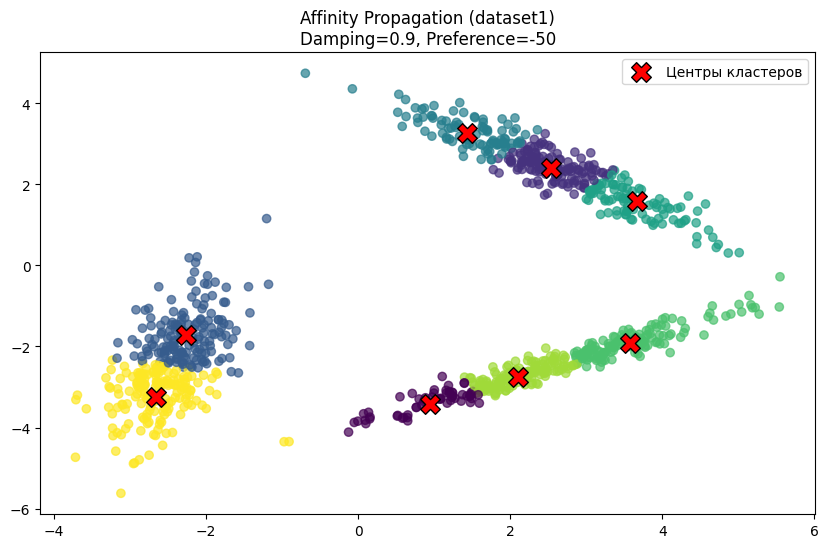

Silhouette Score: 0.471
Calinski-Harabasz Index: 4201.524
Оценка Affinity Propagation на dataset1:
Adjusted Rand Index (ARI): 0.472
Normalized Mutual Info (NMI): 0.694



In [20]:
# Для dataset1
best_params1, best_labels1 = tune_affinity_propagation(X1, "dataset1")

# Обучение
ap1 = AffinityPropagation(**best_params1, random_state=42).fit(X1)
visualize_clustering(
    X1, 
    ap1.labels_,
    ap1.cluster_centers_,
    f'Affinity Propagation (dataset1)\nDamping={best_params1["damping"]}, Preference={best_params1["preference"]}'
)
# Оценка для dataset1 
evaluate_clustering(X1, y1, ap1.labels_, "dataset1", "Affinity Propagation", use_internal=True)

C:\Users\Zver\Desktop\machine_learning\venv\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(



Лучшие параметры для dataset2:
Damping: 0.7
Preference: -50
Silhouette Score: 0.343


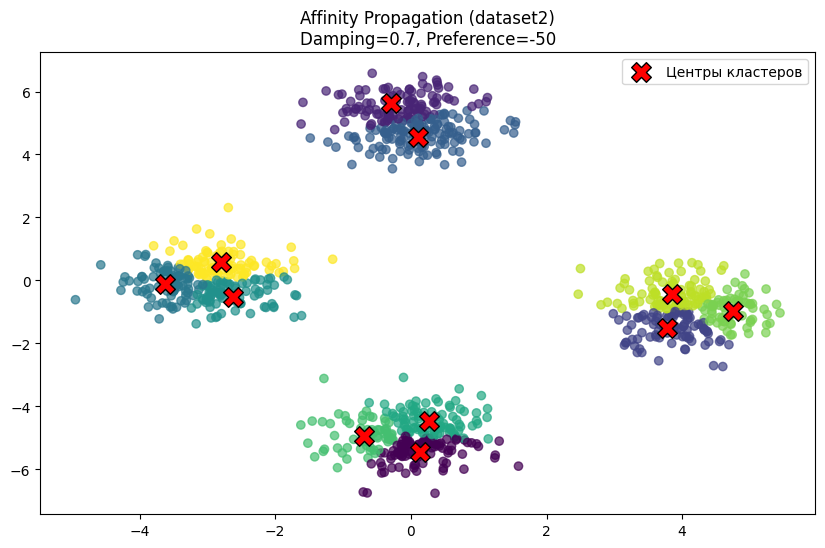

Silhouette Score: 0.343
Calinski-Harabasz Index: 5589.781



In [21]:
# Для dataset2
best_params2, best_labels2 = tune_affinity_propagation(X2, "dataset2")
ap2 = AffinityPropagation(**best_params2, random_state=42).fit(X2)
visualize_clustering(
    X2, 
    ap2.labels_,
    ap2.cluster_centers_,
    f'Affinity Propagation (dataset2)\nDamping={best_params2["damping"]}, Preference={best_params2["preference"]}'
)

evaluate_clustering(X2, y2, ap2.labels_, "dataset2", "Affinity Propagation", use_internal=False)

# Кластеризация для датасета по классификации

In [35]:
# Загрузка данных
df = pd.read_csv(r'C:\Users\Zver\Desktop\ML\data\smoke_detector_task_filtered.csv')
X = df.drop('Fire Alarm', axis=1)  
y = df['Fire Alarm'] 

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучили на наших данных
pca = PCA()
pca.fit(X_scaled)

PCA()

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

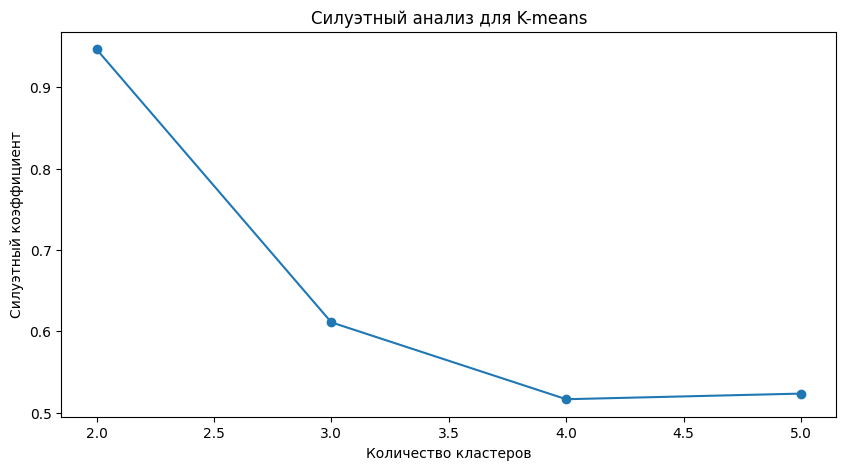

In [38]:
# Метод силуэта
silhouette_scores = []
for k in range(2, 6): 
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.title('Силуэтный анализ для K-means')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.show()

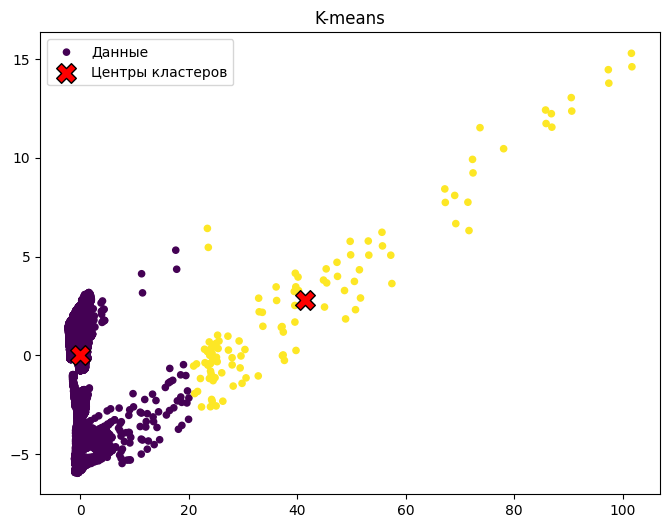

0.9467441714269754

In [39]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_pca)
labels_kmeans = kmeans.labels_


plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', s=20, label='Данные')
plt.scatter(
    kmeans.cluster_centers_[:, 0],   
    kmeans.cluster_centers_[:, 1], 
    s=200,
    marker='X',                
    c='red',                  
    edgecolor='black',         
    linewidth=1,                  
    label='Центры кластеров'
)
plt.title('K-means')
plt.legend()
plt.show()

score = silhouette_score(X_pca, kmeans.labels_)
score

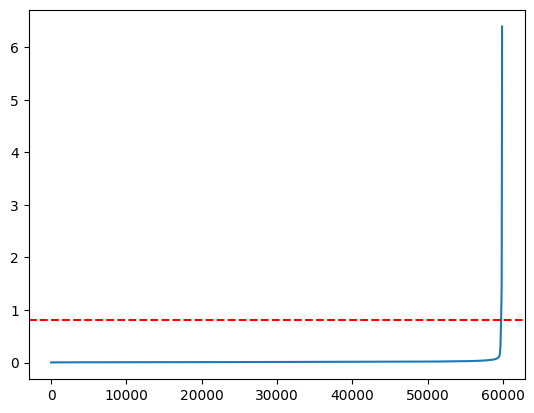

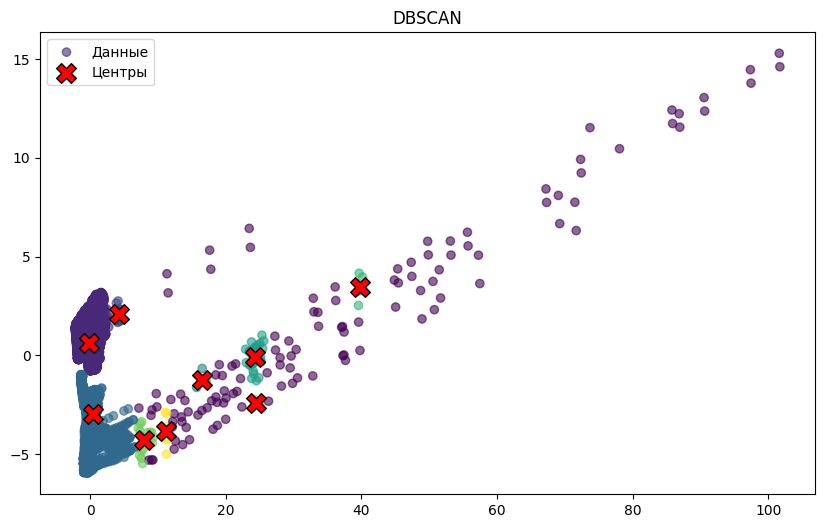

In [40]:
neighbors = NearestNeighbors(n_neighbors=4).fit(X_pca)
distances, _ = neighbors.kneighbors(X_pca)
k_distances = np.sort(distances[:, -1])
plt.plot(k_distances)
plt.axhline(y=0.8, color='r', linestyle='--')
plt.show()

dbscan = DBSCAN(eps=0.8, min_samples=4).fit(X_pca)
labels = dbscan.labels_


plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Данные')

unique_labels = set(labels) - {-1}
if unique_labels:
    cluster_centers = [X_pca[labels == label].mean(axis=0) for label in unique_labels]
    cluster_centers = np.array(cluster_centers)
    plt.scatter(
        cluster_centers[:, 0], cluster_centers[:, 1],
        s=200, marker='X', c='red', edgecolor='black', label='Центры'
    )

plt.title('DBSCAN')
plt.legend()
plt.show()

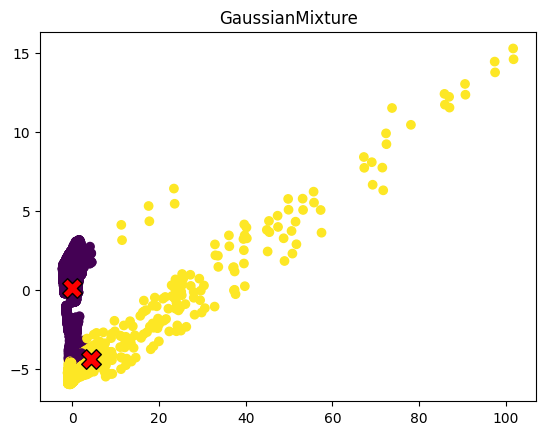

In [41]:
gm = GaussianMixture(n_components=2).fit(X_pca)

gm_labels = gm.predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=gm.predict(X_pca))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=200,  marker='X', c='red', edgecolor='black', linewidth=1)
plt.title('GaussianMixture')
plt.show()

In [42]:
# Оценка метрик
def evaluate_clustering(name, labels):
    print(f'\nОценка {name}:')
    print(f'Silhouette Score: {silhouette_score(X_pca, labels):.3f}')

evaluate_clustering('K-means', kmeans.labels_)
evaluate_clustering('DBSCAN', dbscan.labels_)
evaluate_clustering('GaussianMixture', gm_labels)


Оценка K-means:
Silhouette Score: 0.947

Оценка DBSCAN:
Silhouette Score: 0.587

Оценка GaussianMixture:
Silhouette Score: 0.743
